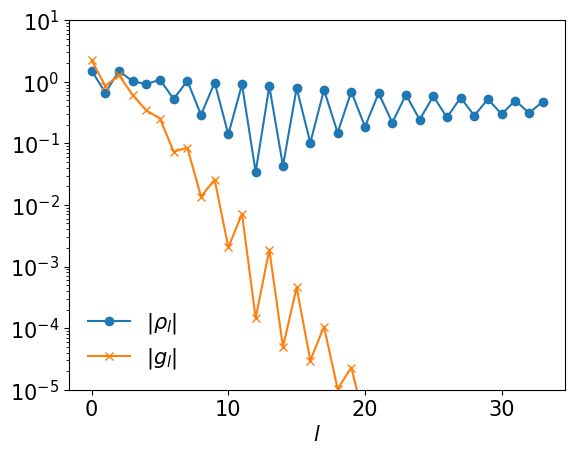

In [1]:
import sparse_ir
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

beta = 15
wmax = 10
basis_b = sparse_ir.FiniteTempBasis("B", beta, wmax, eps=1e-10)

coeff = np.array([1.0])
omega_p = np.array([0.1])

v_omega_p = basis_b.v(omega_p).reshape(-1, omega_p.size)
rhol_pole = np.einsum('lp,p->l', v_omega_p, coeff/np.tanh(0.5*beta*omega_p))
gl_pole = - basis_b.s * rhol_pole

plt.semilogy(np.abs(rhol_pole), marker="o", label=r"$|\rho_l|$")
plt.semilogy(np.abs(gl_pole), marker="x", label=r"$|g_l|$")

plt.xlabel(r"$l$")
plt.ylim([1e-5, 1e+1])
plt.legend(frameon=False)
plt.show()

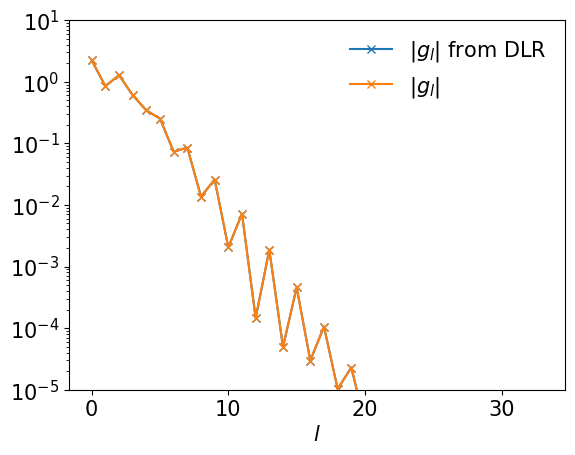

In [2]:
from sparse_ir.dlr import DiscreteLehmannRepresentation
dlr = DiscreteLehmannRepresentation(basis_b, omega_p)
gl_pole2 = dlr.to_IR(coeff/np.tanh(0.5*beta*omega_p))

plt.semilogy(np.abs(gl_pole2), marker="x", label=r"$|g_l|$ from DLR")
plt.semilogy(np.abs(gl_pole), marker="x", label=r"$|g_l|$")

plt.xlabel(r"$l$")
plt.ylim([1e-5, 1e+1])
plt.legend(frameon=False)
plt.show()

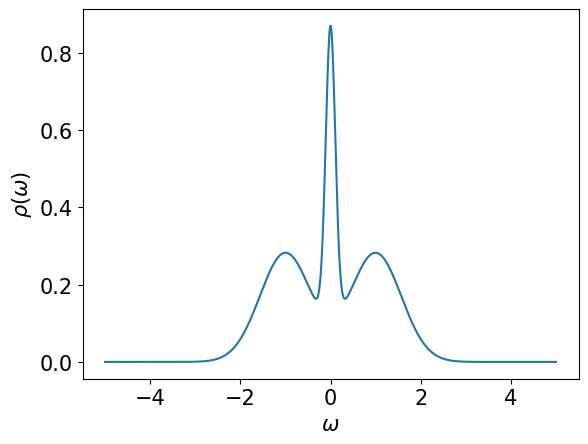

In [3]:
# Three Gaussian peaks (normalized to 1)
gaussian = lambda x, mu, sigma:\
    np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\rho(\omega)$")
plt.plot(omegas, rho(omegas))
plt.show()

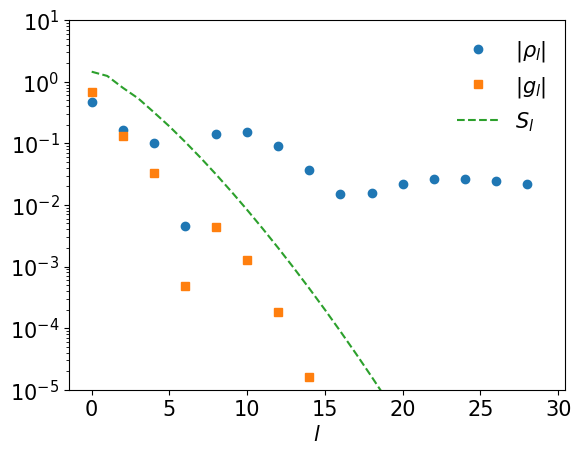

In [4]:
beta = 10
wmax = 10
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=1e-10)

rhol = basis.v.overlap(rho, -wmax, wmax)
gl = - basis.s * rhol

plt.semilogy(np.abs(rhol), marker="o", ls="", label=r"$|\rho_l|$")
plt.semilogy(np.abs(gl), marker="s", ls="", label=r"$|g_l|$")
plt.semilogy(np.abs(basis.s), marker="", ls="--", label=r"$S_l$")
plt.xlabel(r"$l$")
plt.ylim([1e-5, 10])
plt.legend(frameon=False)
plt.show()
#plt.savefig("coeff.pdf")

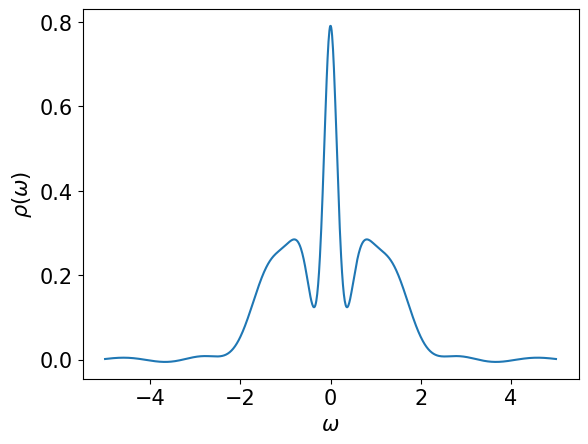

In [5]:
rho_omgea_reconst = basis.v(omegas).T @ rhol

plt.xlabel(r"$\omega$")
plt.ylabel(r"$\rho(\omega)$")
plt.plot(omegas, rho_omgea_reconst)
plt.show()

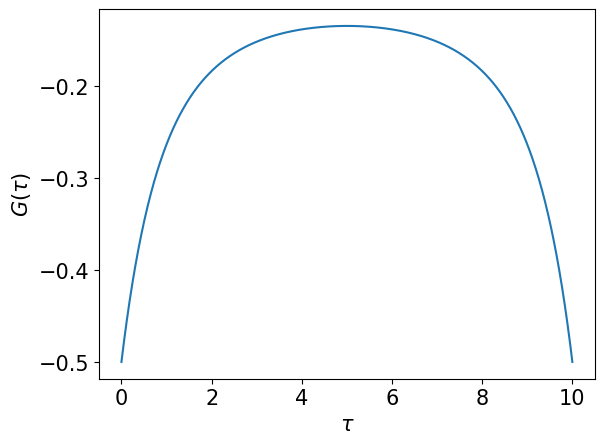

In [6]:
taus = np.linspace(0, beta, 1000)
gtau1 = basis.u(taus).T @ gl
plt.plot(taus, gtau1)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")
plt.show()

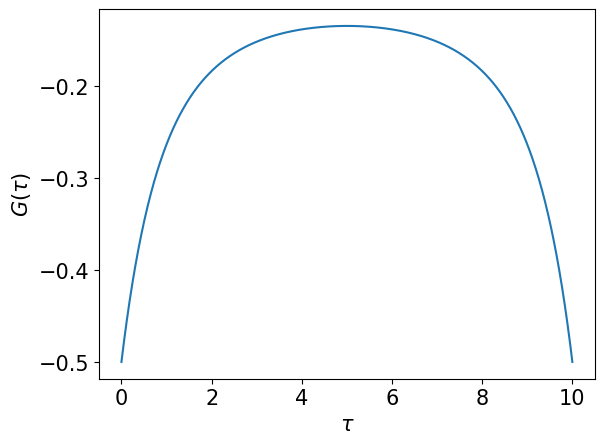

In [7]:
smpl = sparse_ir.TauSampling(basis, taus)
gtau2 = smpl.evaluate(gl)
plt.plot(taus, gtau1)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")
plt.show()

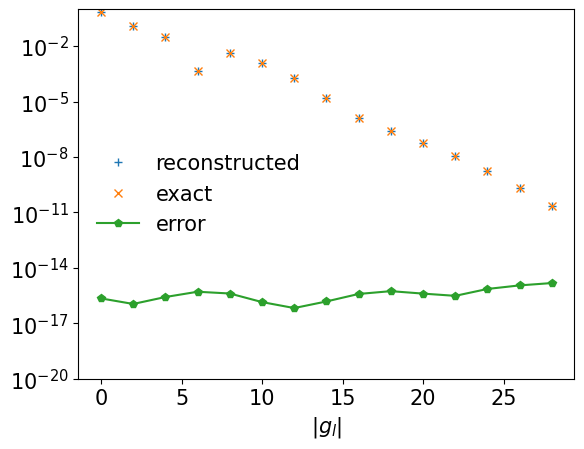

In [8]:
def eval_gtau(taus):
    uval = basis.u(taus) #(nl, ntau)
    if isinstance(taus, np.ndarray):
       print(uval.shape, gl.shape)
       return uval.T @ gl
    else:
       return uval.T @ gl

gl_reconst = basis.u.overlap(eval_gtau, 0, beta)

ls = np.arange(basis.size)
plt.semilogy(ls[::2], np.abs(gl_reconst)[::2], label="reconstructed", marker="+", ls="")
plt.semilogy(ls[::2], np.abs(gl)[::2], label="exact", marker="x", ls="")
plt.semilogy(ls[::2], np.abs(gl_reconst - gl)[::2], label="error", marker="p")
plt.xlabel(r"$l$")
plt.xlabel(r"$|g_l|$")
plt.ylim([1e-20, 1])
plt.legend(frameon=False)
plt.show()

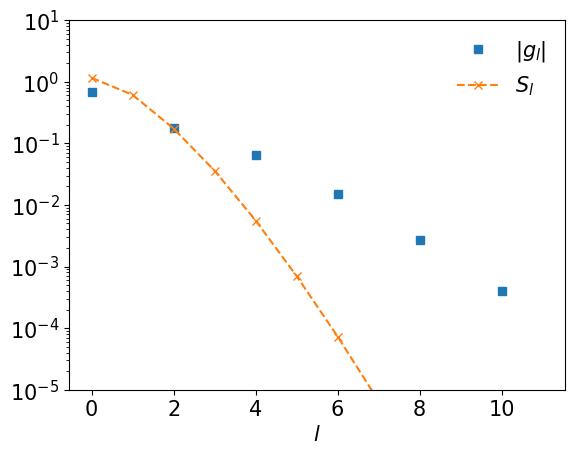

In [9]:
from scipy.integrate import quad

beta = 10
wmax = 0.5
basis_bad = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=1e-10)

# We expand G(τ).
gl_bad = [quad(lambda x: eval_gtau(x) * basis_bad.u[l](x), 0, beta)[0] for l in range(basis_bad.size)]

plt.semilogy(np.abs(gl_bad), marker="s", ls="", label=r"$|g_l|$")
plt.semilogy(np.abs(basis_bad.s), marker="x", ls="--", label=r"$S_l$")
plt.xlabel(r"$l$")
plt.ylim([1e-5, 10])
#plt.xlim([0, basis.size])
plt.legend(frameon=False)
plt.show()
#plt.savefig("coeff_bad.pdf")

In [10]:
np.random.seed(100)
shape = (1,2,3)
gl_tensor = np.random.randn(*shape)[..., np.newaxis] * gl[np.newaxis, :]
print("gl: ", gl.shape)
print("gl_tensor: ", gl_tensor.shape)

gl: 

(30,)

gl_tensor: 

(1, 2, 3, 30)

In [11]:
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
gtau_tensor = smpl_matsu.evaluate(gl_tensor, axis=3)
print("gtau_tensor: ", gtau_tensor.shape)
gl_tensor_reconst = smpl_matsu.fit(gtau_tensor, axis=3)
assert np.allclose(gl_tensor, gl_tensor_reconst)

gtau_tensor: 

(1, 2, 3, 30)